In [23]:
!pip install opencv-python-headless

In [24]:
import cv2
import numpy as np
import pandas as pd

# Load the image
image = cv2.imread('/content/ex1cross.png')

if image is None:
    raise ValueError("Failed to load the image. Check the image path.")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get the negative of the image
#negative = 255 - gray

# Apply Gaussian blur to the negative image
#blurred = cv2.GaussianBlur(negative, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 50)

# Apply Hough Line Transformation
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=20, maxLineGap=10)

# Extract line segments data and store in a list
segments_data = []
for line in lines:
    line = line[0]
    segment_data = {
        'x1': line[0],
        'y1': line[1],
        'x2': line[2],
        'y2': line[3]
    }
    segments_data.append(segment_data)

    # Draw the detected line on the image
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), (0, 255, 255), 2)

# Convert the list to a DataFrame
df_segments = pd.DataFrame(segments_data)

# Save the processed image
output_image_path = '/content/image_LINES.png'
cv2.imwrite(output_image_path, image)

# Save the DataFrame to CSV
csv_path = '/content/detected_segments.csv'
df_segments.to_csv(csv_path, index=False)

# Display paths for reference
print(f"Processed image saved to: {output_image_path}")
print(df_segments)

Processed image saved to: /content/image_LINES.png
         x1    y1    x2    y2
0       120    92  5010    92
1         0     5  5093     5
2       120  2914  5010  2914
3         0  3299  5093  3299
4      3314  2918  5010  2918
...     ...   ...   ...   ...
13288  1859  1145  1879  1141
13289   343   842   368   844
13290  2804  2963  2832  2963
13291  1089  1558  1116  1559
13292  3566  3065  3618  3065

[13293 rows x 4 columns]


In [25]:
# Reload the CSV with the segments
df_segments = pd.read_csv('/content/detected_segments.csv')

# Determine if each segment is "vertical" or "horizontal"
def determine_orientation(row):
    if abs(row['x2'] - row['x1']) > abs(row['y2'] - row['y1']):
        return 'horizontal'
    else:
        return 'vertical'

df_segments['orientation'] = df_segments.apply(determine_orientation, axis=1)

# Filter out shorter segments (less than 30 pixels)
df_segments['length'] = ((df_segments['x2'] - df_segments['x1'])**2 + (df_segments['y2'] - df_segments['y1'])**2)**0.5
df_filtered_segments = df_segments[df_segments['length'] >= 100]

# Save the DataFrame to CSV
csv_path = '/content/detected_segments2.csv'
df_filtered_segments.to_csv(csv_path, index=False)

df_filtered_segments

,x1,y1,x2,y2,orientation,length
0,120,92,5010,92,horizontal,4890.0
1,0,5,5093,5,horizontal,5093.0
2,120,2914,5010,2914,horizontal,4890.0
3,0,3299,5093,3299,horizontal,5093.0
4,3314,2918,5010,2918,horizontal,1696.0
...,...,...,...,...,...,...
12851,1397,3253,1508,3253,horizontal,111.0
12922,1625,3216,1815,3216,horizontal,190.0
13072,2641,3113,2748,3113,horizontal,107.0
13249,2695,2967,2840,2967,horizontal,145.0


In [26]:
import pandas as pd

# Load the segments data
segments_data = pd.read_csv('detected_segments2.csv')

# Split the dataframe into horizontal and vertical segments
horizontal_segments_data = segments_data[segments_data['orientation'] == 'horizontal']
vertical_segments_data = segments_data[segments_data['orientation'] == 'vertical']

# List to store valid intersecting segments and their coordinates
valid_intersections_with_coords = []

# Iterate over the valid intersections
for h_idx, h_seg in horizontal_segments_data.iterrows():
    # Filter potential intersecting vertical segments based on x-coordinate
    potential_intersections = vertical_segments_data[(vertical_segments_data['x1'] >= h_seg['x1']) &
                                                     (vertical_segments_data['x1'] <= h_seg['x2'])]
    # Check y-coordinates for actual intersections
    for v_idx, v_seg in potential_intersections.iterrows():
        if (v_seg['y1'] <= h_seg['y1'] <= v_seg['y2']) or (v_seg['y2'] <= h_seg['y1'] <= v_seg['y1']):

            # Check if segments continue for 30 pixels or more on both sides of intersection
            left_distance = abs(v_seg['x1'] - h_seg['x1'])
            right_distance = abs(v_seg['x1'] - h_seg['x2'])
            up_distance = abs(h_seg['y1'] - v_seg['y1'])
            down_distance = abs(h_seg['y1'] - v_seg['y2'])

            if (left_distance >= 100 and right_distance >= 50) and (up_distance >= 50 and down_distance >= 50):
                valid_intersections_with_coords.append({
                    'Horizontal_Segment_Index': h_idx,
                    'Horizontal_x1': h_seg['x1'],
                    'Horizontal_y1': h_seg['y1'],
                    'Horizontal_x2': h_seg['x2'],
                    'Horizontal_y2': h_seg['y2'],
                    'Vertical_Segment_Index': v_idx,
                    'Vertical_x1': v_seg['x1'],
                    'Vertical_y1': v_seg['y1'],
                    'Vertical_x2': v_seg['x2'],
                    'Vertical_y2': v_seg['y2']
                })

# Convert the list into a DataFrame
valid_intersections_coords_df = pd.DataFrame(valid_intersections_with_coords)
valid_intersections_coords_df

,Horizontal_Segment_Index,Horizontal_x1,Horizontal_y1,Horizontal_x2,Horizontal_y2,Vertical_Segment_Index,Vertical_x1,Vertical_y1,Vertical_x2,Vertical_y2
0,0,120,92,5010,92,721,407,327,407,20
1,0,120,92,5010,92,753,411,329,411,18
2,7,121,88,5009,88,721,407,327,407,20
3,7,121,88,5009,88,753,411,329,411,18
4,17,125,3198,3240,3198,685,1332,3252,1332,2920
...,...,...,...,...,...,...,...,...,...,...
223,968,3637,3105,4154,3105,1253,4062,3171,4062,3012
224,1436,3328,3131,3636,3131,916,3541,3191,3541,3053
225,1436,3328,3131,3636,3131,1155,3544,3192,3544,3053
226,1453,3903,3075,4154,3075,1235,4059,3171,4059,3011


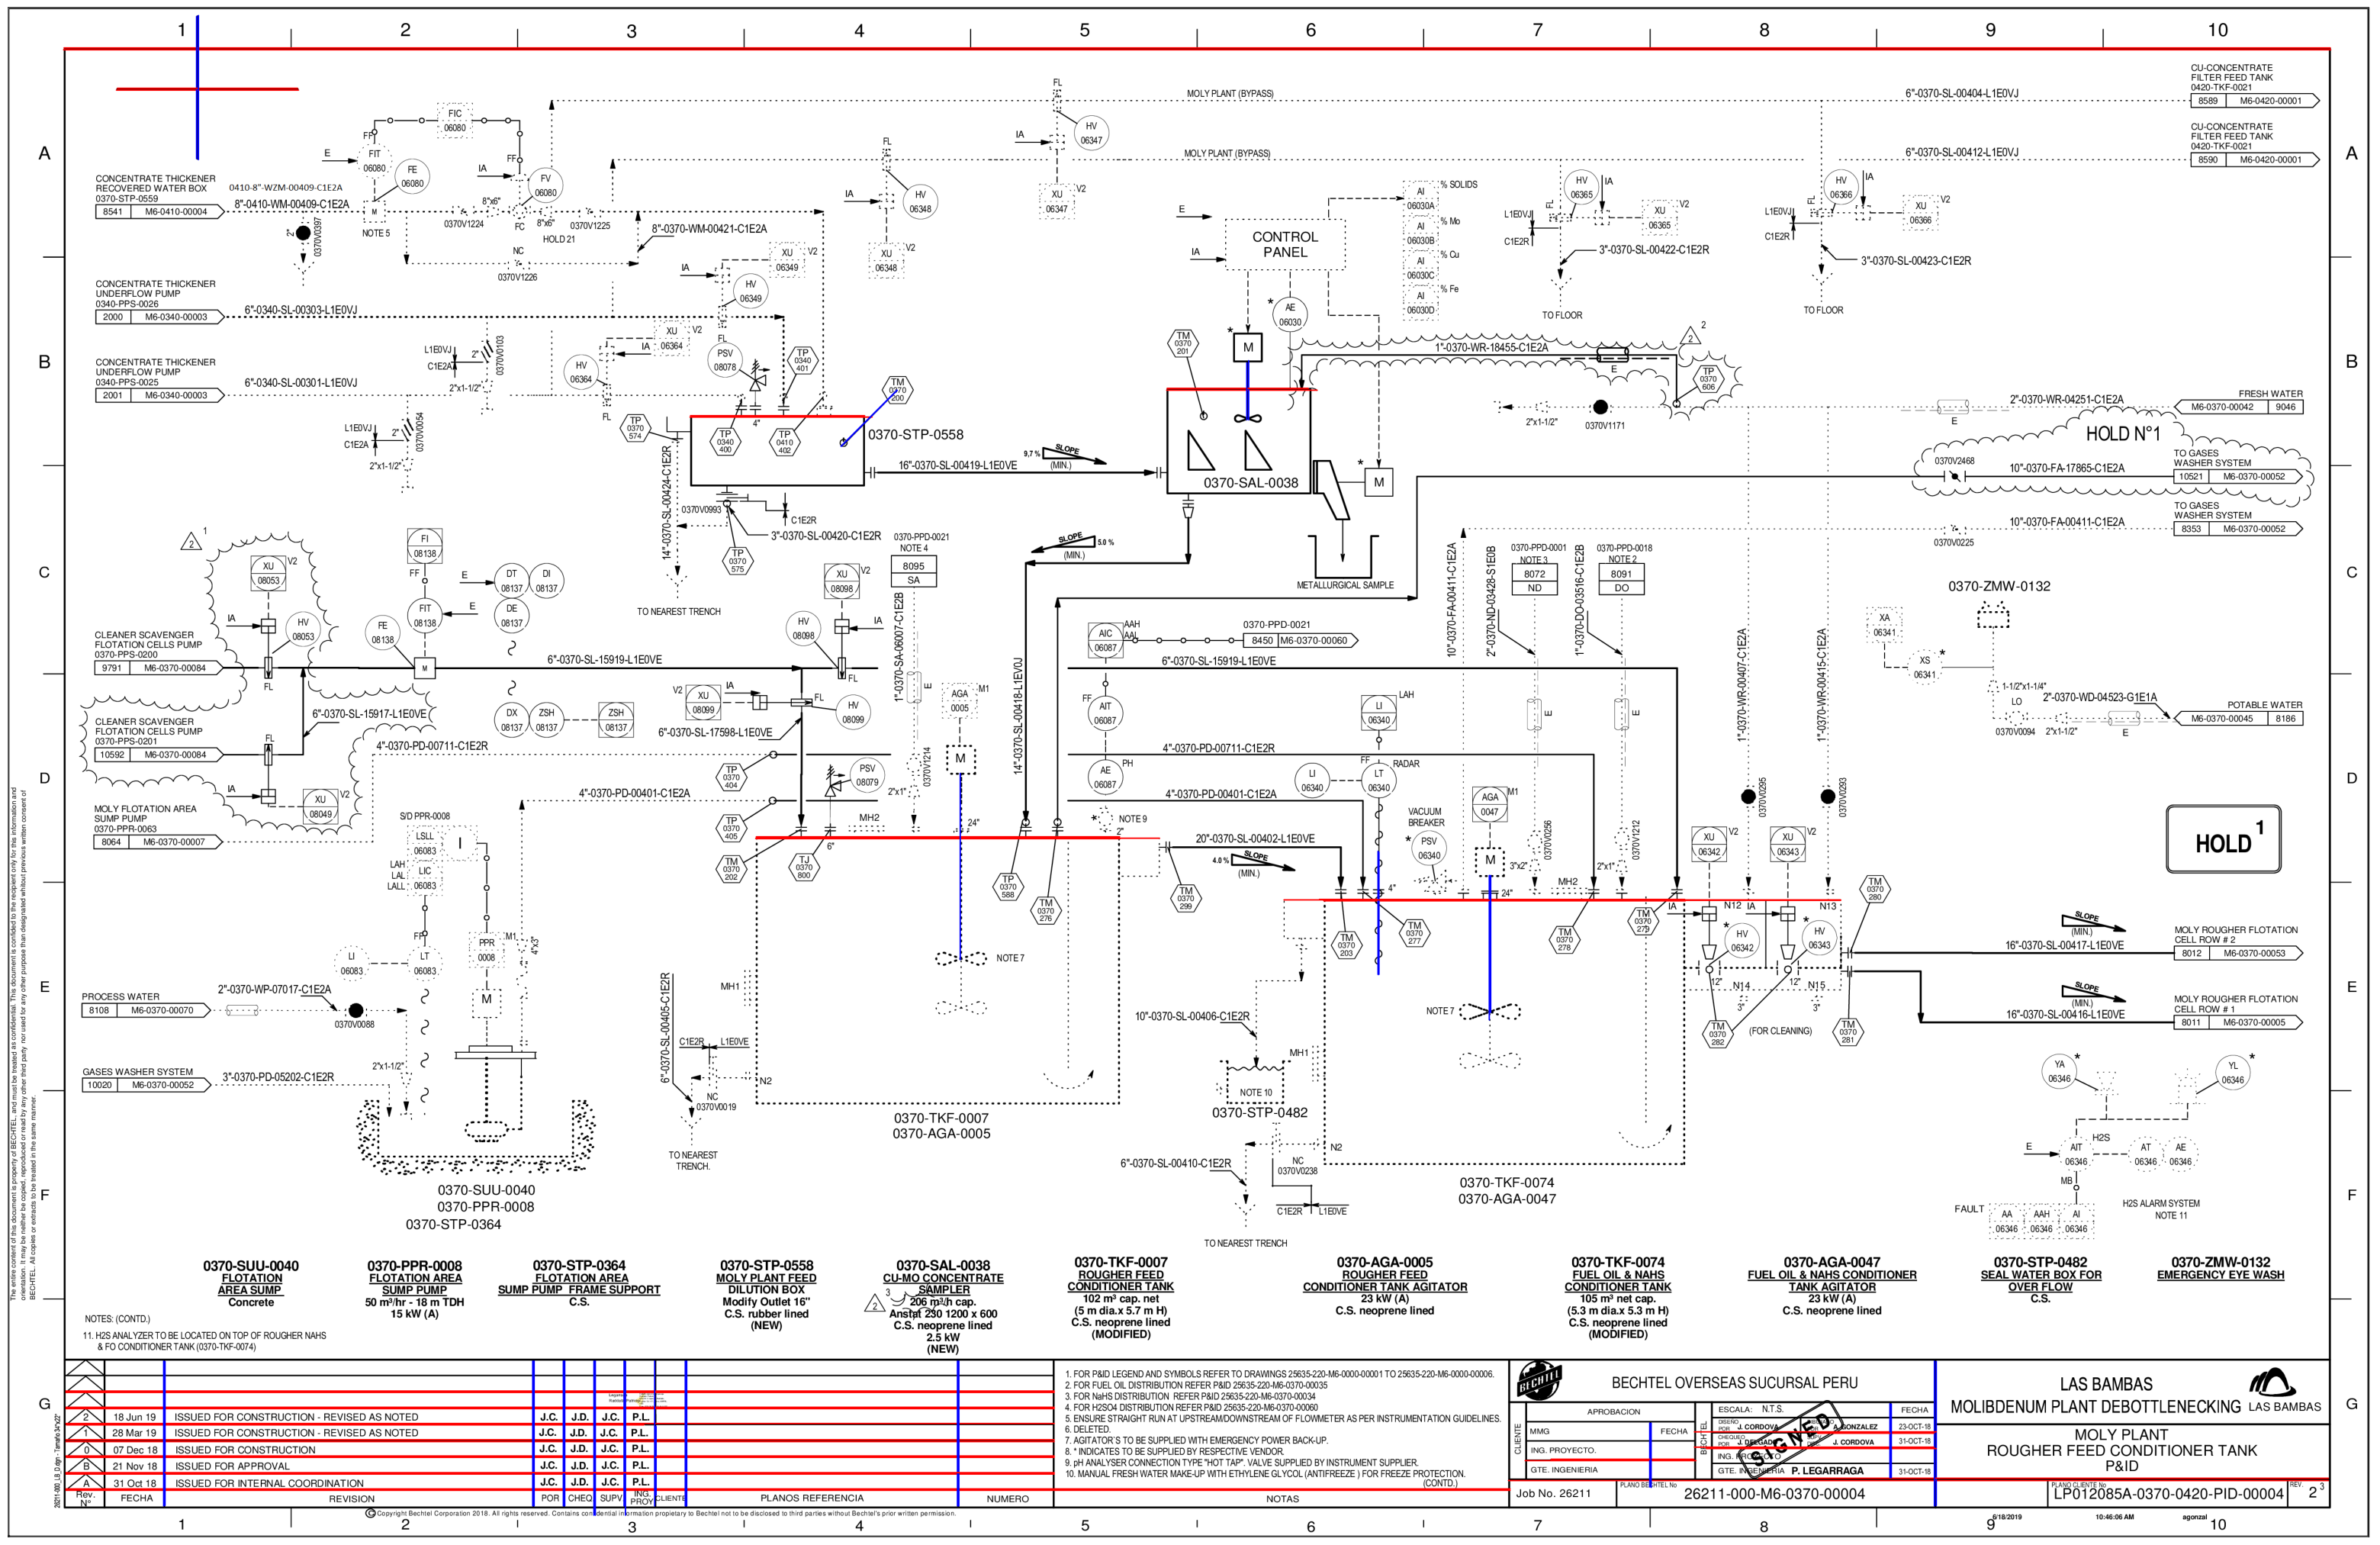

In [27]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Load the image
image_path = 'ex1cross.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Assuming you have valid_intersections_coords_df loaded
# Draw the segments on the image
for _, row in valid_intersections_coords_df.iterrows():
    # Draw horizontal segment
    cv2.line(image_rgb,
             (int(row['Horizontal_x1']), int(row['Horizontal_y1'])),
             (int(row['Horizontal_x2']), int(row['Horizontal_y2'])),
             (255, 0, 0), 2)  # Blue color for horizontal segments

    # Draw vertical segment
    cv2.line(image_rgb,
             (int(row['Vertical_x1']), int(row['Vertical_y1'])),
             (int(row['Vertical_x2']), int(row['Vertical_y2'])),
             (0, 0, 255), 2)  # Red color for vertical segments

# Save the processed image
output_image_path = '/content/image_corrected_final.png'
cv2.imwrite(output_image_path, image_rgb)

# Display the image with the segments
plt.figure(figsize=(40, 40))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
